In [1]:
from typing import final
import numpy as np
# from torch import R
from da_ot import OTGroupLassoDAClassifier, OTBFBDAClassifier
from data import load_battery_data
from plot import plot_continuous_domain_adaptation, plot_accuracies

from sklearn import ensemble
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Ridge
from sklearn import svm

def test_cdot_methods(methods, time_reg_vector, n_samples_source, n_samples_targets,
                      time_length, methods_names=None, cost="seq",
                      fig_name=None, plot_mapping=False):
    
    Xs, ys, Xt, yt, Xt_all, yt_all = load_battery_data(n_samples_source, n_samples_targets, time_length, True)
    mapped_samples = []

    scores = np.zeros([len(methods), time_length])
    losses = np.zeros([len(methods), time_length])
    ots = np.arange(time_length)
    results = []
    gamma = []

    for m, da_clf in enumerate(methods):
        print("Running ", methods_names[m])
        temp_samples = []
        result1 = np.zeros([time_length, yt_all[0].shape[0]])
        gamma1 = []

        for k in range(time_length):
            if k > 0:
                if cost == "seq":
                    da_clf.fit(temp_samples[-1], ys, Xt[k], treg=time_reg_vector[m], Gamma_old=da_clf.Gamma,
                               Xt_old=Xt[k - 1])
                    print("---seq---")
                else:
                    # da_clf.fit(Xs, ys, Xt[k], treg=time_reg_vector[m], Gamma_old=da_clf.Gamma,
                    #            Xt_old=Xt[k - 1])
                    da_clf.fit(Xs, ys, Xt[k])
                    print("---direct---")
            else:
                da_clf.fit(Xs, ys, Xt[k])
                
            temp_samples.append(da_clf.adapt_source_to_target())

            result = da_clf.predict(Xt_all[k])
            result1[k, :] = result
            scores[m, k] = r2_score(yt_all[k], result)
            losses[m, k] = mean_squared_error(yt_all[k], result)
            gamma1.append(da_clf.Gamma)
        
        gamma.append(gamma1)
        results.append(result1)
        mapped_samples.append(temp_samples)
        # if plot_mapping:
        #     for k in range(time_length):
        #         plot_continuous_domain_adaptation(Xt, yt, mapped_samples, ys, methods_names=methods_names, time_idx=k,
        #                                           fig_name=fig_name + "_time_" + str(
        #                                               k) + "_geom.png" if fig_name is not None else None)

    # plot_accuracies(ots, scores, methods_names=methods_names,
    #                 fig_name='./fig/' + fig_name + "_" + str(time_length) + "_accuracy.png" if fig_name is not None else None)
    # plot_accuracies(ots, losses, methods_names=methods_names,
    #                 fig_name='./fig/' + fig_name + "_" + str(time_length) + "_loss.png" if fig_name is not None else None)
  

    return scores, losses, ots, results, ys, yt, mapped_samples, Xt, Xs, gamma, yt_all


In [2]:
N_RUNS = 10

# clf = KNeighborsClassifier(n_neighbors=1)
# clf = ensemble.RandomForestRegressor(n_estimators=4)
# clf = Ridge(alpha=0.1)
clf = svm.SVR()
from sklearn import tree
# clf = tree.DecisionTreeRegressor()

ot_group_lasso = OTGroupLassoDAClassifier(clf, reg=0.5, eta=10)
ot_group_lasso_treg = OTGroupLassoDAClassifier(clf, reg=0.5, eta=10)
ot_BFB = OTBFBDAClassifier(clf, reg=0.1, regnorm=None, it=50, epochs=1000, lr=10, verbose=True)

# methods = [ot_group_lasso, ot_group_lasso_treg, ot_BFB]
# methods_names =  ['ot_group_lasso', 'ot_group_lasso_treg', 'ot_BFB']
# time_reg_vector = [0, 50, 50]

methods = [ot_BFB]
methods_names =  ['ot_BFB']
time_reg_vector = [50]


time = 9
target = 10
cost = ["seq", "direct"]
final_scores = np.zeros([len(cost), time])
final_losses = np.zeros([len(cost), time])
all_results = []
all_mapped_samples = []
all_gamma = []

for i, c in enumerate(cost):
    print('-----{} ot-----'.format(c))

    run_scores = []
    run_losses = []

    for run in range(N_RUNS):
        print("RUN %d..." % run)
        scores, losses, ots, results, ys, yt, mapped_samples, Xt, Xs, gamma, yt_all = test_cdot_methods(
            methods=methods,
            methods_names=methods_names,
            time_reg_vector=time_reg_vector,
            fig_name="seq_run_" + str(run),
            time_length=time,
            n_samples_source=67,
            n_samples_targets=target,
            plot_mapping=False,
            cost=c,
        )
        run_scores.append(scores)
        run_losses.append(losses)
        print('----scores----')
        print(scores)
        print('----losses----')
        print(losses)

    all_results.append(results)
    all_mapped_samples.append(mapped_samples)
    all_gamma.append(gamma)

    avg_scores = np.mean(np.array(run_scores), axis=0)
    avg_losses = np.mean(np.array(run_losses), axis=0)

    final_scores[i, :] = avg_scores
    final_losses[i, :] = avg_losses

# plot_accuracies(ots, final_scores, methods_names=cost, fig_name="./fig/" + "tsvm_s05_run_{}_tcnt_{}_avg_accuracy.png".format(time, target))
# plot_accuracies(ots, final_losses, methods_names=cost, fig_name="./fig/" + "tsvm_s05_run_{}_tcnt_{}_avg_loss.png".format(time, target))

# plot_accuracies(ots, final_scores, methods_names=cost)
plot_accuracies(ots, final_losses, methods_names=cost)

-----seq ot-----
RUN 0...
Running  ot_BFB
---seq---
---seq---
---seq---
---seq---
---seq---
---seq---
---seq---
---seq---
----scores----
[[-4.06788593 -1.34980737  0.74861549  0.15124718  0.12379816  0.06424196
   0.03476394  0.01056966 -0.00775844]]
----losses----
[[0.12357027 0.05729536 0.00612951 0.02069514 0.02136443 0.02281659
  0.02353535 0.02412528 0.02457218]]
RUN 1...
Running  ot_BFB
---seq---
---seq---
---seq---
---seq---
---seq---
---seq---
---seq---
---seq---
----scores----
[[-3.72770234  0.81267807  0.53157164  0.31605311  0.09473893  0.04315136
  -0.00480949 -0.00805132 -0.01159066]]
----losses----
[[0.11527557 0.00456747 0.01142169 0.01667668 0.02207298 0.02333084
  0.02450027 0.02457932 0.02466562]]
RUN 2...
Running  ot_BFB
---seq---
---seq---
---seq---
---seq---
---seq---
---seq---
---seq---
---seq---
----scores----
[[-3.47782177  0.42814018  0.09300141  0.03207732  0.01236666 -0.00656779
  -0.01134127 -0.01222517 -0.01235444]]
----losses----
[[0.10918274 0.01394366 0.

TypeError: plot_accuracies() missing 2 required positional arguments: 'scores' and 'vars'

In [ ]:
print(all_results[0][0].shape)
print(yt_all[1]==yt_all[2])

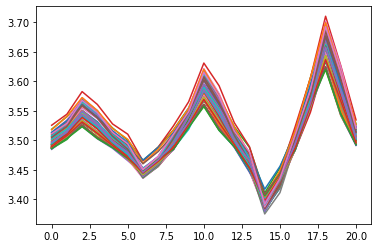

In [3]:
import matplotlib.pyplot as plt
for i in range(Xs.shape[0]):
    plt.plot(Xs[i])

In [ ]:
all_mapped_samples[0][0][8].shape

In [ ]:
Xt[0].shape

In [ ]:
all_gamma[1][0][8].shape

In [ ]:
yt_all[0].shape

In [ ]:
import matplotlib.pyplot as plt
transport_time = 8
plt.scatter(np.arange(yt_all[0].shape[0]), yt_all[transport_time], label = 'true')
plt.scatter(np.arange(yt_all[0].shape[0]), all_results[0][0][transport_time, :], label = 'seq')
plt.scatter(np.arange(yt_all[0].shape[0]), all_results[1][0][transport_time, :], label = 'direct')
plt.legend()

plt.grid()

In [ ]:
print("seq: ", mean_squared_error(yt_all[transport_time], all_results[0][0][transport_time, :]))
print("direct: ", mean_squared_error(yt_all[transport_time], all_results[1][0][transport_time, :]))

In [ ]:
all_results[0][0][transport_time, :]

In [ ]:
print(np.mean(yt[transport_time]))
print(np.mean(all_results[1][0][transport_time, :]))
print(np.mean((yt[0]-1.7)**2))

In [ ]:
plt.imshow(all_gamma[0][0][0], interpolation='nearest')
plt.colorbar()

plt.title('OT matrix sinkhorn')

In [ ]:
from sklearn.decomposition import KernelPCA
import ot.plot
kpca = KernelPCA(n_components=2, kernel='rbf', gamma=30)

transport_time = 1

kpca.fit(all_mapped_samples[0][0][transport_time])
mapped_s = kpca.transform(all_mapped_samples[0][0][transport_time]) 

kpca.fit(all_mapped_samples[1][0][transport_time])
direct_mapped_s = kpca.transform(all_mapped_samples[1][0][transport_time]) 

kpca.fit(Xt[transport_time])
xt0 = kpca.transform(Xt[transport_time])
print(xt0.shape)
kpca.fit(Xs)
xs0 = kpca.transform(Xs)
print(xs0.shape)
# ot.plot.plot2D_samples_mat(xs0, xt0, all_gamma[0][0][transport_time], color=[.5, .5, 1], alpha = 0.1)

# plt.scatter(mapped_s[:, 0], mapped_s[:, 1], marker='o', s=20, label = 'seq mapped source')
# plt.scatter(direct_mapped_s[:, 0], direct_mapped_s[:, 1], marker='o', s=20, label = 'direct mapped source')
# plt.scatter(xt0[:, 0], xt0[:, 1], marker='o', s=20, label = 'target')
# plt.scatter(xs0[:, 0], xs0[:, 1], marker='o', s=20, label = 'source')
# plt.legend()



In [ ]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = Axes3D(fig)
ot.plot.plot2D_samples_mat(xs0, xt0, all_gamma[0][0][transport_time], color=[.5, .5, 1], alpha = 0.1)

ax.scatter(mapped_s[:, 0], mapped_s[:, 1], ys, marker='o', s=20, label = 'seq mapped source')
ax.scatter(direct_mapped_s[:, 0], direct_mapped_s[:, 1], ys, marker='o', s=20, label = 'direct mapped source')
ax.scatter(xt0[:, 0], xt0[:, 1], yt[transport_time], marker='o', s=20, label = 'target')
ax.scatter(xs0[:, 0], xs0[:, 1], ys, marker='o', s=20, label = 'source')
plt.legend()
plt.show()

In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)

transport_time = 8

pca.fit(all_mapped_samples[0][0][transport_time])
mapped_s = pca.transform(all_mapped_samples[0][0][transport_time]) 

pca.fit(all_mapped_samples[1][0][transport_time])
direct_mapped_s = pca.transform(all_mapped_samples[1][0][transport_time]) 

pca.fit(Xt[transport_time])
xt0 = pca.transform(Xt[transport_time])

pca.fit(Xs)
xs0 = pca.transform(Xs)

# ot.plot.plot2D_samples_mat(xs0, xt0, all_gamma[0][0][transport_time], color=[.5, .5, 1], alpha = 0.1)

plt.scatter(mapped_s[:, 0], mapped_s[:, 1], marker='o', s=20, label = 'mapped source')
plt.scatter(direct_mapped_s[:, 0], direct_mapped_s[:, 1], marker='o', s=20, label = 'direct mapped source')
plt.scatter(xt0[:, 0], xt0[:, 1], marker='o', s=20, label = 'target')
plt.scatter(xs0[:, 0], xs0[:, 1], marker='o', s=20, label = 'source')
plt.legend()


Text(0, 0.5, 'Voltage')

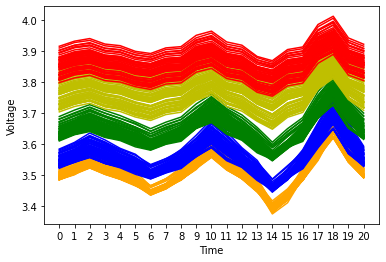

In [47]:
import pandas as pd
dir = '/Users/liuhanbing/Desktop/code/out_SOC_005-075_excel/'
s_val = pd.read_excel(dir + 'out-SOC-005.xlsx', engine='openpyxl').values
Xs = s_val[:, 2 : 23].astype(np.float64)
ys = s_val[:, 1].astype(np.float64)
for i in range(Xs.shape[0]):
    plt.plot(Xs[i], c='orange')

s_val = pd.read_excel(dir + 'out-SOC-010.xlsx', engine='openpyxl').values
Xs = s_val[:, 2 : 23].astype(np.float64)
ys = s_val[:, 1].astype(np.float64)
for i in range(Xs.shape[0]):
    plt.plot(Xs[i], c='b')

# s_val = pd.read_excel(dir + 'out-SOC-015.xlsx', engine='openpyxl').values
# Xs = s_val[:, 2 : 23].astype(np.float64)
# ys = s_val[:, 1].astype(np.float64)
# for i in range(Xs.shape[0]):
#     plt.plot(Xs[i], c='g')

s_val = pd.read_excel(dir + 'out-SOC-020.xlsx', engine='openpyxl').values
Xs = s_val[:, 2 : 23].astype(np.float64)
ys = s_val[:, 1].astype(np.float64)
for i in range(Xs.shape[0]):
    plt.plot(Xs[i], c='g')

# s_val = pd.read_excel(dir + 'out-SOC-025.xlsx', engine='openpyxl').values
# Xs = s_val[:, 2 : 23].astype(np.float64)
# ys = s_val[:, 1].astype(np.float64)
# for i in range(Xs.shape[0]):
#     plt.plot(Xs[i], c='r')

# s_val = pd.read_excel(dir + 'out-SOC-030.xlsx', engine='openpyxl').values
# Xs = s_val[:, 2 : 23].astype(np.float64)
# ys = s_val[:, 1].astype(np.float64)
# for i in range(Xs.shape[0]):
#     plt.plot(Xs[i], c='c')

s_val = pd.read_excel(dir + 'out-SOC-035.xlsx', engine='openpyxl').values
Xs = s_val[:, 2 : 23].astype(np.float64)
ys = s_val[:, 1].astype(np.float64)
for i in range(Xs.shape[0]):
    plt.plot(Xs[i], c='y')   

# s_val = pd.read_excel(dir + 'out-SOC-040.xlsx', engine='openpyxl').values
# Xs = s_val[:, 2 : 23].astype(np.float64)
# ys = s_val[:, 1].astype(np.float64)
# for i in range(Xs.shape[0]):
#     plt.plot(Xs[i], c='gold')

s_val = pd.read_excel(dir + 'out-SOC-045.xlsx', engine='openpyxl').values
Xs = s_val[:, 2 : 23].astype(np.float64)
ys = s_val[:, 1].astype(np.float64)
for i in range(Xs.shape[0]):
    plt.plot(Xs[i], c='r')

# s_val = pd.read_excel(dir + 'out-SOC-050.xlsx', engine='openpyxl').values
# Xs = s_val[:, 2 : 23].astype(np.float64)
# ys = s_val[:, 1].astype(np.float64)
# for i in range(Xs.shape[0]):
#     plt.plot(Xs[i], c='orange')
plt.xticks(range(21))
plt.xlabel('Time')
plt.ylabel('Voltage')

Text(0, 0.5, 'Capacity')

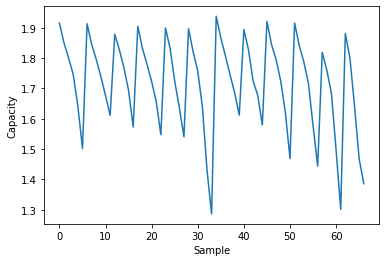

In [50]:
plt.plot(ys)
plt.xlabel('Sample')
plt.ylabel('Capacity')

Text(0.5, 0, 'Number of intermediate domains')

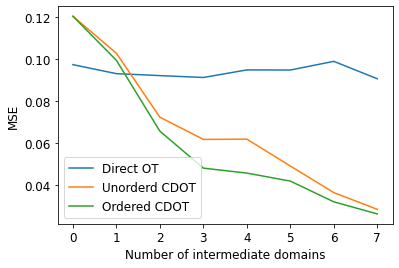

In [77]:
direct = [0.09731929, 0.093022587, 0.092091589, 0.091192888, 0.09480394, 0.094755865, 0.098891718, 0.090574358]
unorder_seq = [0.120422287, 0.10274427, 0.072256746, 0.061634906, 0.061761016, 0.048944161, 0.036243492, 0.028271149]
order_seq = [0.120422287, 0.099381488, 0.065564025, 0.04792728, 0.045558934, 0.041740947, 0.031837464, 0.026075433]
plt.plot(direct, label='Direct OT')
plt.plot(unorder_seq, label='Unorderd CDOT')
plt.plot(order_seq, label='Ordered CDOT')
plt.legend(fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.ylabel('MSE', fontsize=12)
plt.xlabel('Number of intermediate domains', fontsize=12)